<a href="https://colab.research.google.com/github/xinconggg/Machine-Learning/blob/main/Processing%20Sequences%20using%20RNNs%20and%20CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Recurrent Neurons and Layers
### Recurrent Neurons
Recurrent neurons are specialized neurons used in Recurrent Neural Networks (RNNs). Unlike traditional neurons, which process input and pass it forward, recurrent neurons also **retain a memory of past inputs* by feeding their output back into themselves.
- **Traditional neurons:** Output is based only on current input.
- **Recurrent neurons:** Output depends on both the current input and the previous output, creating a feedback loop.

This feedback mechanism allows RNNs to process sequential data and recognize patterns over time, making them suitable for tasks like time-series forecasting, language modeling, and speech recognition.

## Recurrent Layers
A recurrent layer is a layer made up of multiple recurrent neurons, each processing a different part of the input sequence.

Each time step involves:
- **Receiving input** for the current time step.
- **Retaining information**- from previous time steps via internal memory.
- **Producing an output** for the current time step.

### Memory Cells
Memory cells are the key components that enable recurrent neurons to retain information over time.
- **Short-Term Memory:** RNNs retain information from recent time steps but struggle to remember distant past information.
- **Long-Term Memory:** Enhanced RNN architectures like *LSTMs* (Long Short-Term Memory) and *GRUs* (Gated Recurrent Units) introduce special gates to maintain information for longer periods, solving the vanishing gradient problem.

### Input and Output Sequences
RNNs can handle various input-output sequence formats:<br>
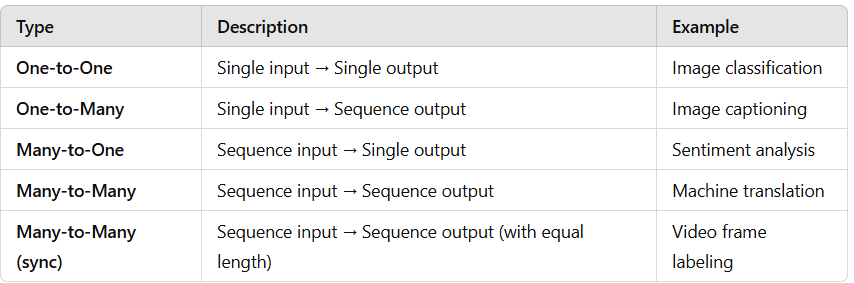


## Forecasting a Time Series
Suppose the task is to build a model capable of forecasting the **number of passengers that will rideon bus and rail the next day**. We have access to daily ridership data since 2001. To handle this task, start by loading and cleaning up the data:

In [1]:
import pandas as pd

url = "https://raw.githubusercontent.com/xinconggg/data/refs/heads/main/CTA_-_Ridership_-_Daily_Boarding_Totals.csv"
df = pd.read_csv(url, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"] # Rename columns to shorter names
df = df.sort_values("date").set_index("date") # Sort by date and set the index
df = df.drop("total", axis=1) # Drop the "total" column
df = df.drop_duplicates() # Remove duplicates

print(df.head())

           day_type     bus    rail
date                               
2001-01-01        U  297192  126455
2001-01-02        W  780827  501952
2001-01-03        W  824923  536432
2001-01-04        W  870021  550011
2001-01-05        W  890426  557917


On 1st January 2001, 297,192 people boarded a bus in Chicago and 126,455 boarded a train. The `day_type` column contains "W" for Weekdays, "A" for Saturdays and "U" for Sundays or holidays.

Now let's plot the bus and rail ridership figures over a few months in 2019:

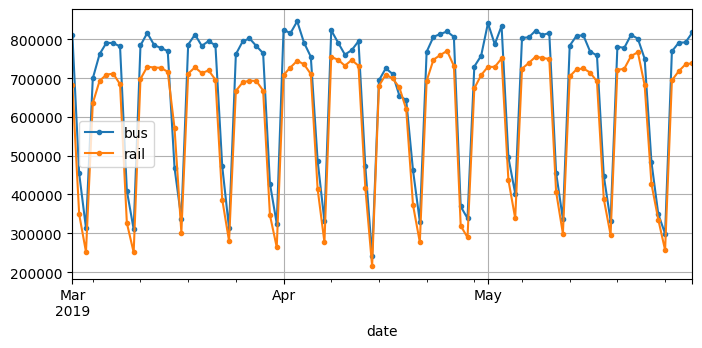

In [2]:
import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

Note that Pandas includes both the start and end month in the range, so this plots the data from the 1st of March till the 31st of May.

**Multivariate Time Series:** There are multiple values per time step

**Univariate Time Series:** If we only look at the bus column then there will only be a single value per time step

**Naive Forecasting:** A simple prediction method that assumes future values will be the same as the most recent observed value

To visualize naive forecasts, let's overlay the 2 time series (bus and rail) as well as the same time series lagged by one week, using dotted lines. We'll also plot the difference between the two, also known as "differencing":

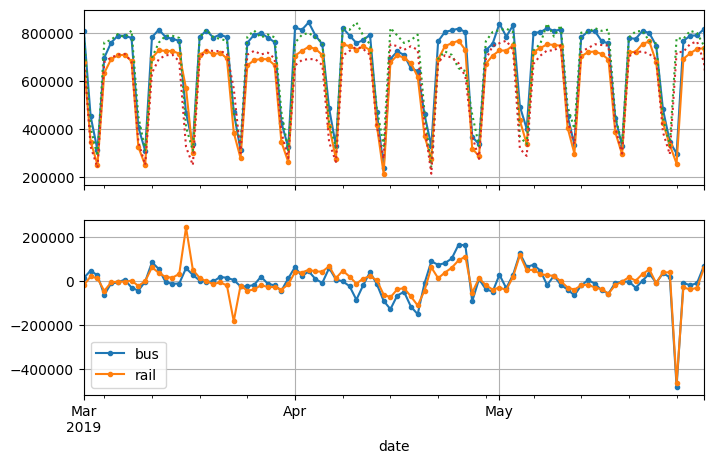

In [3]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series
axs[0].set_ylim([170_000, 900_000])  # beautifies the plot
plt.show()

Notice how closely the lagged time series track the actual time series. When a time series is correlated with a lagged version of itself, the time series is **autocorrelated**. In this case, most of the differences are fairly small, except for the end of May. Therefore, we should check if there was a holiday at that time, which might cause this difference:

In [4]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

Indeed, there was a long weekend back then. Now let's measure the mean absolute error (MAE) over the 3-month period - March, April and May 2019:

In [5]:
diff_7.abs().mean()

,0
bus,43915.608696
rail,42143.271739


The naive forecast model gets an MAE of about 43,916 bus riders and about 42,143 rail riders. It's hard to tell whether the model is performing good or bad, so let's put the forecast errors into perspective by dividing them by the target values:

In [6]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

,0
bus,0.082938
rail,0.089948


The output is the Mean Absolute Percentage Error (MAPE). The model gives us a MAPE of roughly 8.3% for bus and 9.0% for rail.

Looking at the time series, there doesn't appear to be any significant monthly seasonaliy, but let's check if there's any yearly seasonality. We'll look at the data from 2001 to 2019. To reduce the risk of data snooping, ignore more recent data for now. We will also plot a 12-month rolling average for each series to visualize long-term trends:

<ipython-input-7-327adc1d454b>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df[["bus", "rail"]].resample('M').mean()


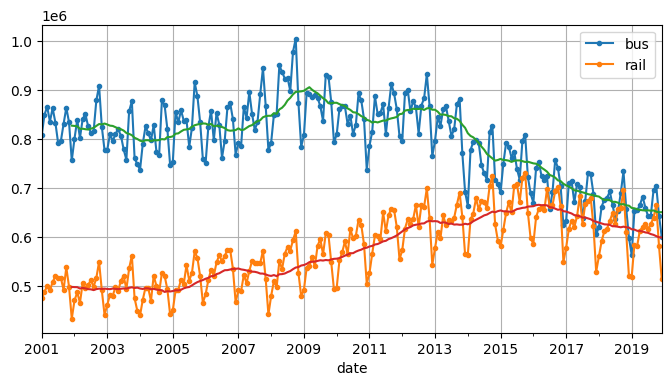

In [7]:
# Select only numeric columns before resampling
df_monthly = df[["bus", "rail"]].resample('M').mean()

# Compute the 12-month rolling average for the given period
period = slice("2001", "2019")
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

# Plot the data
fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

From the forecasting, there's definitely some yearly seasonality. Check what we get if we plot the 12-month difference:

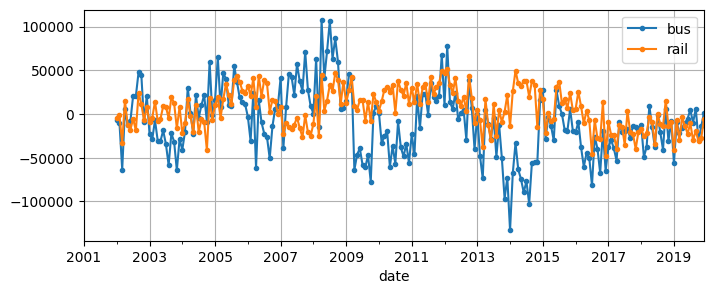

In [8]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
plt.show()

The yearly seasonality and long-term trend has dissapeared. Differencing is a common technique used to remove trend and seasonality from a time series, making it easier to study a *stationary* time series.

### ARIMA (Autoregressive Moving Average)
The ARIMA model is a widely used time-series forecasting technique that combines three components: **AutoRegressive (AR)**, **Integrated (I)**, and **Moving Average (MA)**.

The **AR** part models the relationship between an observation and a specified number of lagged observations (past values).

The **I** part represents the differencing of raw observations to make the series stationary.

The **MA** part models the relationship between an observation and a residual error from a moving average model applied to lagged observations.

ARIMA is suitable for **univariate time-series** data that shows patterns, trends, and seasonality, and is often used to predict future points in a series based on its past values.








#### SARIMA (Seasonal ARIMA)
One member of the ARIMA family is SARIMA, which models the time series in the same way as ARIMA, but it additionally models a seasonal component for a given frequency (e.g. weekly), using the same ARIMA approach.

Suppose today is the last day of May 2019, and we want to forecast the rail ridership for tommorow (1st June 2019). TO do so, we can use `statsmodels` library, which contains many different statistical models, including ARIMA and its variants:

In [9]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series,
              order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast()
y_pred

,0
2019-06-01,427758.62641


In [10]:
df["rail"].loc["2019-06-01"] # target value

379044

The forecast outputs 427,759 passengers, when in fact there were 379,044. The forecast is 12.9% off, which is pretty bad. To check if we're just unlucky that day, we can run the same code in a loop to make forecasts every day in March, April and May, then compute the MAE over that period:

In [11]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],  # train on data up to "today"
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 1, 7))
    model = model.fit()  # note that we retrain the model every day!
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()
mae # returns 32040.720089453378

<ipython-input-11-a93f8c624149>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
<ipython-input-11-a93f8c624149>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
<ipython-input-11-a93f8c624149>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
<ipython-input-11-a93f8c624149>:10: FutureWarning: Series.__getitem__ treating keys as positions is dep

32040.720089453378

The MAE is about 32,041 which is significantly lower than the MAE we got with naive forecasting (42,143). Although the SARIMA model is not perfect, it still performs better than naive forecasting significantly.

### Preparing the Data for Machine Learning Models
Keras has a function called `tf.keras.utils.timeseries_dataset_from_array` to help us prepare the training set. It takes a time series as input and builds a `tf.data.Dataset`, containing all the windows of the desired length as well as their corresponding targets. Below is an example that takes a time series containing the numbers 0 to 5 and creates a dataset containing all the windows of length 3, with their corresponding targets grouped into batches of size 2:

In [12]:
import tensorflow as tf

my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],  # the targets are 3 steps into the future
    sequence_length=3,
    batch_size=2
)
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

Each sample in the dataset is a window of length 3, along with its corresponding target. The windows are [0,1,2], [1,2,3] and [2,3,4], and their respective targets are 3, 4 and 5.

Before starting training, we need to split the data into a training, validation and test period. We must first scale it down by a factor of one million, to ensure the values are near the 0-1 range:

In [13]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

Now we can use `timeseries_dataset_from_array` to create datasets for training and validation. Since gradient descent expects the instances in the training set to be independent and identically distributed (IID), we must set the argument `shuffle=True` to shuffle the training windows:

In [14]:
seq_length = 56
tf.random.set_seed(42)

train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

Now we're ready to build and train any model.

### Forecasting using a Linear Model
First, try Huber Loss, which usually works better than minimizing the MAE directly. We'll also use early stopping:

In [15]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500,
                    callbacks=[early_stopping_cb])

Epoch 1/500


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5439 - mae: 0.9623 - val_loss: 0.0763 - val_mae: 0.3431
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0342 - mae: 0.2053 - val_loss: 0.0083 - val_mae: 0.1017
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 - mae: 0.0849 - val_loss: 0.0047 - val_mae: 0.0695
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0070 - mae: 0.0813 - val_loss: 0.0043 - val_mae: 0.0650
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - mae: 0.0774 - val_loss: 0.0041 - val_mae: 0.0634
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - mae: 0.0694 - val_loss: 0.0040 - val_mae: 0.0614
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - mae: 0.0783 - val_loss: 0.0037 - val_mae: 0.0598
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0060 - mae: 0.0738 - val_loss: 0.0036 - val_mae: 0.0591
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - mae: 0.

In [16]:
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019 - mae: 0.0381 


37007.19773769379

The model reaches a validation MAE of about 37,007. It performed better than naive forecasting, but still worse than SARIMA model.

### Forecasting using a Simple RNN
Let's try the most basic RNN, containing a simple recurrent layer with just 1 recurrent neuron:

In [17]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
# Define a utility function
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [19]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.6958 - mae: 1.1121 - val_loss: 0.0660 - val_mae: 0.3172
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0588 - mae: 0.2872 - val_loss: 0.0370 - val_mae: 0.2044
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0269 - mae: 0.1617 - val_loss: 0.0179 - val_mae: 0.1482
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0188 - mae: 0.1697 - val_loss: 0.0177 - val_mae: 0.1421
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0189 - mae: 0.1662 - val_loss: 0.0173 - val_mae: 0.1394
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0179 - mae: 0.1615 - val_loss: 0.0167 - val_mae: 0.1406
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0170 - mae: 0.1585 - val_loss: 0.0163 - val_mae: 0.1393
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0166 - mae: 0.1594 - val_loss: 0.0159 - val_mae: 0.1395
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - lo

102773.68873357773

With MAE of 102,774, the performance is very poor. To improve the performance, try creating a model with a larger recurrent layer, containing 32 recurrent neurons, and add a dense output layer on top of it with a single output neuron and no activation function. Now, the recurrent layer will be able to carry much more information and the dense output layer will project the final output from 32 dimensions down to 1:

In [20]:
tf.random.set_seed(42)

univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)  # no activation function by default
])

In [21]:
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0875 - mae: 0.3466 - val_loss: 0.0090 - val_mae: 0.1202
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0090 - mae: 0.1046 - val_loss: 0.0039 - val_mae: 0.0682
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0040 - mae: 0.0655 - val_loss: 0.0031 - val_mae: 0.0621
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0039 - mae: 0.0618 - val_loss: 0.0025 - val_mae: 0.0513
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0035 - mae: 0.0569 - val_loss: 0.0022 - val_mae: 0.0456
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0046 - mae: 0.0654 - val_loss: 0.0022 - val_mae: 0.0415
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0032 - mae: 0.0525 - val_loss: 0.0019 - val_mae: 0.0374
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0036 - mae: 0.0552 - val_loss: 0.0026 - val_mae: 0.0429
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - lo

29433.410614728928

Now, its validation MAE is 29,433, which is the best model so far, beating the SARIMA model.

### Forecasting using a Deep RNN
It is quite common to stack multiple layers of cells, which gives us a deep RNN. Implementing a deep RNN in Keras is straightforward: just stack recurrent layers. In the following example, 3 `SimpleRNN` layers will be used. The first 2 layers are *sequence-to-sequence* layers and the last one is a *sequence-to-vector* layer. Finally, the `Dense` layer produces the model's forecast:

In [22]:
tf.random.set_seed(42)

deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [23]:
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.1329 - mae: 0.3518 - val_loss: 0.0086 - val_mae: 0.1143
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 0.0099 - mae: 0.1183 - val_loss: 0.0055 - val_mae: 0.0880
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.0058 - mae: 0.0765 - val_loss: 0.0037 - val_mae: 0.0656
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0055 - mae: 0.0727 - val_loss: 0.0022 - val_mae: 0.0468
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0046 - mae: 0.0656 - val_loss: 0.0022 - val_mae: 0.0449
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0038 - mae: 0.0588 - val_loss: 0.0032 - val_mae: 0.0586
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0044 - mae: 0.0602 - val_loss: 0.0021 - val_mae: 0.0428
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0038 - mae: 0.0552 - val_loss: 0.0019 - val_mae: 0.0379
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - lo

28350.939974188805

The model reaches an MAE of about 28,351, beating the previous, "shallower" RNN.

### Forecasting Multivariate Time Series
In the following example, we try to forecast the rail time series using both the bus and rail data as input. We will also throw in the day type. Since we can always know in advance whether the next day is going to be a weekday, weekend or a holiday, we can shift the day type series 1 day into the future, so that the model is given tomorrow's day type as input:

In [24]:
df_mulvar = df[["bus", "rail"]] / 1e6  # use both bus & rail series as input
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # we know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar)  # one-hot encode the day type

Now `df_mulvar` is a DataFrame with 5 columns, the bus and rail data, plus 3 columns containing the one-hot encoding of the next day's type. Next, we split the data into 3 periods for training, validation and testing:

In [25]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

Then we create the dataset:

In [26]:
import numpy as np

# Ensure all data is numeric and handle NaNs
mulvar_train = mulvar_train.astype(np.float32).fillna(0)
mulvar_valid = mulvar_valid.astype(np.float32).fillna(0)

tf.random.set_seed(42)

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),  # use all 5 columns as input
    targets=mulvar_train["rail"][seq_length:],  # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

Lastly, we create the RNN:

In [27]:
tf.random.set_seed(42)

mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds,
                 learning_rate=0.05)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0523 - mae: 0.2494 - val_loss: 0.0037 - val_mae: 0.0716
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0036 - mae: 0.0653 - val_loss: 0.0011 - val_mae: 0.0369
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0016 - mae: 0.0395 - val_loss: 0.0014 - val_mae: 0.0423
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0015 - mae: 0.0392 - val_loss: 0.0012 - val_mae: 0.0394
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0015 - mae: 0.0383 - val_loss: 9.7350e-04 - val_mae: 0.0344
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0012 - mae: 0.0357 - val_loss: 0.0016 - val_mae: 0.0478
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0013 - mae: 0.0371 - val_loss: 7.3904e-04 - val_mae: 0.0274
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0013 - mae: 0.0356 - val_loss: 7.1582e-04 - val_mae: 0.0261
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15

23421.581834554672

The model reaches a validation MAE of 23,421, which is a big progress.

### Forecasting Several Time Steps Ahead
So far we have only predicted the value at the next time step, but we could just as easily have predicted the value several steps ahead by changing the targets appropriately.

One way to predict the next 14 values is to predict all 14 next values at once:

In [29]:
tf.random.set_seed(42)

def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)
ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

In [30]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds,
                 learning_rate=0.02)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1376 - mae: 0.4149 - val_loss: 0.0244 - val_mae: 0.1742
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0198 - mae: 0.1605 - val_loss: 0.0152 - val_mae: 0.1321
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0149 - mae: 0.1375 - val_loss: 0.0126 - val_mae: 0.1196
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0130 - mae: 0.1270 - val_loss: 0.0107 - val_mae: 0.1115
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0111 - mae: 0.1171 - val_loss: 0.0092 - val_mae: 0.1049
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0101 - mae: 0.1117 - val_loss: 0.0082 - val_mae: 0.0987
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0093 - mae: 0.1045 - val_loss: 0.0070 - val_mae: 0.0927
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0082 - mae: 0.0987 - val_loss: 0.0063 - val_mae: 0.0871
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - lo

34106.46319389343

In [32]:
import numpy as np

X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


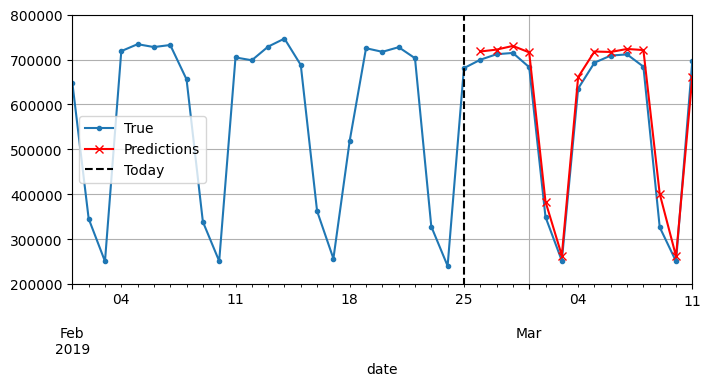

In [33]:
# The forecasts start on 2019-02-26, as it is the 57th day of 2019, and they end on 2019-03-11. That's 14 days in total.
Y_pred = pd.Series(X[0, -14:, 0],
                   index=pd.date_range("2019-02-26", "2019-03-11"))

fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(
    label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
plt.show()

## Handling Long Sequences
To train an RNN on long sequences, we must run it over many time steps, making the unrolled RNN a very deep network. Just like any deep neural network, it may suffer from unstable gradients problem: it may take forever to train, or training may be unstable.

### Fighting the Unstable Gradients Problem
Many of the tricks used in deep nets to alleviate the unstable gradients problem can also be used for RNNs: good parameter initialization, faster optimizers, dropout, and so on. However, nonsaturating activation functions (e.g., ReLU) may not help as much here.

One form of normalization which often works great with RNNs is *Layer Normalization*. Similar to *Batch Normalization*, instead of normalizing across the batch dimension, it normalizes across the features dimension.

To implement *Layer Normalization* in Keras, we need to define a custom memory cell, which is jsut like a regular layer except its `call` method takes 2 arguments: the inputs at the current time step and the hidden states from the previous time step. The following code implements a custom memory cell that will behave like a `SimpleRNNCell`, except it will also apply layer normalization at each step:


In [34]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units,
                                                             activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

Walk through of the code:
- The `LNSimpleRNNCell` class inherits from the `tf.keras.layers.Layer` class, just like any custom layer.
- The constructor takes the number of units and the desired activation function and sets the `state-size` and `output_size` attributes, then creates a `SimpleRNNCell` with no activation function. Then the constructor creates the `LayerNormalization` layer and finally fetches the desired activation function.
- The `call` method starts by applying the `SimpleRNNCell`, which computes a linear combination of the current inputs and the previous hidden states and it returns the result twice. Next, the `call` method applies layer normalization, followed by the activation function. Finally, it returns the output twice: once as the outputs, and once as the new hidden states. To use this custom cell, all we need to do is create a `tf.keras.layers.RNN` layer, passing it to a cell instance:

In [35]:
tf.random.set_seed(42)

custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True,
                        input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
